### 导入实验环境

https://bbs.huaweicloud.com/blogs/344369

#### 导入库

In [1]:
import os
import struct
import sys
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
import numpy as np

import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import context
from mindspore.nn.metrics import Accuracy, Loss
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore import Tensor

context.set_context(mode=context.GRAPH_MODE, device_target='CPU') 


#### 定义常量

In [2]:
cfg = edict({
    'train_size': 60000,  # 训练集大小
    'test_size': 10000,  # 测试集大小
    # 'train_size': 600,  # 训练集大小
    # 'test_size': 100,  # 测试集大小
    'channel': 1,  # 图片通道数
    'image_height': 28,  # 图片高度
    'image_width': 28,  # 图片宽度
    'batch_size': 256,
    'num_classes': 10,  # 分类类别
    'lr': 0.001,  # 学习率
    'epoch_size': 10,  # 训练次数
    'data_dir_train': os.path.join('fashion-mnist', 'train'),
    'data_dir_test': os.path.join('fashion-mnist', 'test'),
}) 


## 数据读取和预处理

### 定义函数用于读取数据

In [3]:
def read_image(file_name):
    '''
    :param file_name: 文件路径
    :return:  训练或者测试数据
    如下是训练的图片的二进制格式
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>IIII', file_content, 0)  # 取前4个整数，返回一个元组
    offset = struct.calcsize('>IIII')
    imgNum = head[1]  # 图片数
    width = head[2]  # 宽度
    height = head[3]  # 高度
    bits = imgNum * width * height  # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    imgs_array = np.array(imgs, np.float32).reshape((imgNum, width * height))  # 最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array


def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label, np.int32)


def get_data():
    # 文件获取
    train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
    test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
    train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
    test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
    # 读取数据
    train_x = read_image(train_image)
    test_x = read_image(test_image)
    train_y = read_label(train_label)
    test_y = read_label(test_label)
    return train_x, train_y, test_x, test_y


### 数据预处理

训练数据集样本数： 60000
测试数据集样本数： 10000
通道数/图像长/宽： (1, 28, 28)
一张图像的标签样式： 9


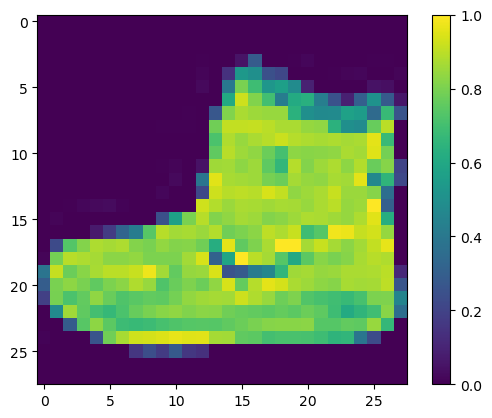

In [4]:
train_x, train_y, test_x, test_y = get_data()
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
train_x = train_x / 255.0
test_x = test_x / 255.0

print('训练数据集样本数：', train_x.shape[0])
print('测试数据集样本数：', test_y.shape[0])
print('通道数/图像长/宽：', train_x.shape[1:])
print('一张图像的标签样式：', train_y[0])  # 一共10类，用0-9的数字表达类别。

plt.figure()
plt.imshow(train_x[0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()


### 数据集预处理

In [5]:
# 转换数据类型为Dataset
def create_dataset():
    XY_train = list(zip(train_x, train_y))
    ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
    ds_train = ds_train.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    XY_test = list(zip(test_x, test_y))
    ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
    ds_test = ds_test.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    return ds_train, ds_test 


## 回调函数声明

In [6]:
# 定义一个自定义的回调函数，继承自Callback类
from mindspore.train.callback import Callback
class EvalCallBack(Callback):
    def __init__(self, model, train_dataset, test_dataset, dataset_sink_mode = False, epochs_to_eval = 1):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        # epochs_to_eval是一个int数字，代表着：每隔多少个epoch进行一次验证
        self.epochs_to_eval = epochs_to_eval
        self.per_eval = {"epoch": [], "test_acc": [], "train_acc": [], "test_loss": [], "train_loss": []}
        self.dataset_sink_mode = dataset_sink_mode

    def epoch_end(self, run_context):
        # 获取到现在的epoch数
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        # 如果达到进行验证的epoch数，则进行以下验证操作
        if cur_epoch % self.epochs_to_eval == 0:
            # 此处model设定的metrics是准确率Accuracy
            train_acc = self.model.eval(self.train_dataset, dataset_sink_mode=self.dataset_sink_mode)["train_acc"]
            test_acc = self.model.eval(self.test_dataset, dataset_sink_mode=self.dataset_sink_mode)["test_acc"]
            train_loss = self.model.eval(self.train_dataset, dataset_sink_mode=self.dataset_sink_mode)["train_loss"]
            test_loss = self.model.eval(self.test_dataset, dataset_sink_mode=self.dataset_sink_mode)["test_loss"]
            self.per_eval["epoch"].append(cur_epoch)
            self.per_eval["test_acc"].append(test_acc)
            self.per_eval["train_acc"].append(train_acc)
            self.per_eval["train_loss"].append(test_acc)
            self.per_eval["test_loss"].append(train_acc)
            print("Epoch{}: train_acc: {}, test_acc: {}, train_loss: {}, test_loss{}".format(cur_epoch, train_acc, test_acc, train_loss, test_loss))


## NetWork

### BaseLine NetWork

In [7]:
# 定义卷积神经网络，BaseLine
class ForwardFashion_baseline(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashion_baseline, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(128 * 11 * 11, 128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### Network With BN

In [8]:
# 定义卷积神经网络，批量归一化
class ForwardFashionWithBatchNorm(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionWithBatchNorm, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(3200, 128)
        self.bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        # x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        # x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

### NetWork with Dropout

In [19]:
# 定义卷积神经网络，有Dropout正则化
class ForwardFashionWithDropout(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionWithDropout, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.8)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(3200, 128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Network With BatchNorm And Dropout

In [10]:
# 定义卷积神经网络，批量归一化
class ForwardFashionWithBatchNormAndDropout(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionWithBatchNormAndDropout, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(3200, 128)
        self.bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Dense(128, self.num_class)
        self.dropout = nn.Dropout()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 损失函数

### L1正则 

In [11]:
from mindspore import ops
# 定义具有L1正则化的交叉熵损失函数
class L1CrossEntropyLoss(nn.Cell):
    def __init__(self, params, l1_weight = 1e-4, reduction = "mean"):
        super(L1CrossEntropyLoss, self).__init__(reduction)
        self.params = params
        self.ce = nn.CrossEntropyLoss()
        self.l1 = nn.L1Regularizer(l1_weight)
        self.reduce_sum = ops.ReduceSum()
        self.concat = ops.Concat(axis=0)
        self.reshape = ops.Reshape()

    def construct(self, pred, label):
        flatten_params = self.concat([self.reshape(p, (-1,)) for p in self.params])
        ce_loss = self.ce(pred, label)
        l1_loss = self.reduce_sum(self.l1(flatten_params))      # 计算L1范数惩罚项
        total_loss = ce_loss + l1_loss
        return total_loss

### L2正则

In [12]:
from mindspore import ops
# 定义具有L2正则化的交叉熵损失函数
class L2CrossEntropyLoss(nn.Cell):
    def __init__(self, params, l2_weight = 1e-4, reduction = "mean"):
        super(L2CrossEntropyLoss, self).__init__(reduction)
        self.params = params
        self.ce = nn.CrossEntropyLoss()
        self.l1 = nn.L1Regularizer(1)
        self.l2_weight = l2_weight
        self.reduce_sum = ops.ReduceSum()
        self.concat = ops.Concat(axis=0)
        self.reshape = ops.Reshape()

    def construct(self, pred, label):
        flatten_params = self.concat([self.reshape(p, (-1,)) for p in self.params])
        ce_loss = self.ce(pred, label)
        l1_loss = self.reduce_sum(self.l1(flatten_params)) * self.reduce_sum(self.l1(flatten_params)) * self.l2_weight      # 计算L1范数惩罚项
        total_loss = ce_loss + l1_loss
        return total_loss

In [13]:
# # 定义卷积神经网络，BaseLine
# class ForwardFashion(nn.Cell):
#     def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
#         super(ForwardFashion, self).__init__()
#         self.num_class = num_class
#         self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
#         self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
#         self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
#         self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.relu = nn.ReLU()
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Dense(128 * 11 * 11, 128)
#         self.fc2 = nn.Dense(128, self.num_class)

#     def construct(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.conv3(x)
#         x = self.relu(x)
#         x = self.maxpool2d(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x
    

# def train_FTRL(Net):
#     ds_train, ds_test = create_dataset()
#     # 构建网络
#     network = Net(cfg.num_classes)
#     # 定义模型的损失函数，优化器    
#     net_loss = nn.CrossEntropyLoss(reduction="mean")
#     net_opt = nn.Adam(network.trainable_params(), cfg.lr)
#     conv_params = list(filter(lambda x: 'conv' in x.name, network.trainable_params()))
#     no_conv_params = list(filter(lambda x: 'conv' not in x.name, network.trainable_params()))
#     group_params = [{'params': conv_params, 'weight_decay': 0.01, 'grad_centralization':True},
#                     {'params': no_conv_params},
#                     {'order_params': network.trainable_params()}]
#     optim = nn.FTRL(group_params, learning_rate=0.1, weight_decay=0.0)
#     # 训练模型
#     model = Model(network, loss_fn=net_loss, optimizer=optim, metrics={'acc': Accuracy()})
#     loss_cb = LossMonitor()
#     print("============== Starting Training ==============")
#     model.train(cfg.epoch_size, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
#     # 验证
#     metric = model.eval(ds_test)
#     print(metric)
#     return model

# model_FTRL = train_FTRL(ForwardFashion)


## 辅助函数

In [14]:
def train(network, loss_fn):
    ds_train, ds_test = create_dataset()
    # 定义模型的损失函数，优化器    
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    # 训练模型
    model = Model(network, loss_fn=loss_fn, optimizer=net_opt, metrics={'test_acc': Accuracy(), 'train_acc': Accuracy(), 'test_loss': Loss(),  'train_loss': Loss()})
    loss_cb = EvalCallBack(model=model, train_dataset=ds_train, test_dataset=ds_test)
    print("============== Starting Training ==============")
    model.train(cfg.epoch_size, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    print(loss_cb.per_eval)
    metricDic = loss_cb.per_eval
    return model, metricDic

In [15]:
def saveMetric(path, metric):
    with open(path, encoding="utf8", mode="w") as f:
        f.write(str(metric))

In [16]:
def saveModel(path, model):
    mindspore.save_checkpoint(model, path)

In [17]:
from matplotlib import pyplot as plt
def drawAndSaveFig(path, metricList, title):
    label = ["train_acc", "test_acc", "train_loss", "test_loss"]
    plt.plot(metricList[label[0]], metricList[label[1]])
    plt.legend(label[:2])
    plt.title(title + "_acc")
    plt.show()
    plt.savefig(path+"_acc")
    plt.plot(metricList[label[2]], metricList[label[3]])
    plt.legend(label[2:])
    plt.title(title + "_loss")
    plt.show()
    plt.savefig(path+"_loss")

## 测试

### BaseLine

In [21]:
# Baseline
network = ForwardFashion_baseline(cfg.num_classes)
loss_fn = nn.CrossEntropyLoss()
model, metricDic = train(network, loss_fn)
saveMetric("./metric/baseline_metric.txt", metricDic)
saveModel("./model/baseline_model.ckpt", network)

[WARNING] ME(32400:23808,MainProcess):2023-05-18-21:50:49.730.00 [mindspore\train\model.py:1094] For EvalCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


============== Starting Training ==============
Epoch1: train_acc: 0.8442674946581197, test_acc: 0.8347355769230769, train_loss: 0.4406767497714768, test_loss0.4667505866441971
Epoch2: train_acc: 0.8802250267094017, test_acc: 0.8673878205128205, train_loss: 0.3334465340161935, test_loss0.36994184591831303
Epoch3: train_acc: 0.9018596420940171, test_acc: 0.8862179487179487, train_loss: 0.26995841369160223, test_loss0.31915530753441346
Epoch4: train_acc: 0.904296875, test_acc: 0.8858173076923077, train_loss: 0.26382560378465897, test_loss0.3162946907373575
Epoch5: train_acc: 0.9163494925213675, test_acc: 0.8939302884615384, train_loss: 0.22728929254743788, test_loss0.2983479110094217
Epoch6: train_acc: 0.9305722489316239, test_acc: 0.9017427884615384, train_loss: 0.18974674289297855, test_loss0.28005740428582215
Epoch7: train_acc: 0.9398704594017094, test_acc: 0.9067508012820513, train_loss: 0.16848084690351772, test_loss0.26954165177467543
Epoch8: train_acc: 0.9446280715811965, test_acc

In [ ]:
drawAndSaveFig("./img/metric_baseLine", metricDic, "BaseLine")

### L1

In [36]:
# L1
network_L1 = ForwardFashion_baseline(cfg.num_classes)
loss_fn_L1 = L1CrossEntropyLoss(network_L1.trainable_params(), l1_weight=1e-8)
model_L1, metricDic_L1 = train(network_L1, loss_fn_L1)
saveMetric("./metric/baseline_metric_L1.txt", metricDic_L1)
saveModel("./model/baseline_model_L1.ckpt", network_L1)

[WARNING] ME(15008:31020,MainProcess):2023-05-18-11:47:11.686.819 [mindspore\train\model.py:1094] For EvalCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


============== Starting Training ==============
Epoch1: train_acc: 0.10011017628205128, test_acc: 0.0999599358974359, train_loss: 2.329673836373875, test_loss2.329674243927002
Epoch2: train_acc: 0.09990985576923077, test_acc: 0.0999599358974359, train_loss: 2.329407216137291, test_loss2.3294081626794276
Epoch3: train_acc: 0.09999332264957266, test_acc: 0.10006009615384616, train_loss: 2.3296092055801654, test_loss2.3296094979995337
Epoch4: train_acc: 0.10001001602564102, test_acc: 0.10006009615384616, train_loss: 2.3294762780523706, test_loss2.3294756901569857
Epoch5: train_acc: 0.10002670940170941, test_acc: 0.10016025641025642, train_loss: 2.330023269368033, test_loss2.330022096633911
Epoch6: train_acc: 0.10001001602564102, test_acc: 0.09975961538461539, train_loss: 2.3295277937864647, test_loss2.329527885485918
Epoch7: train_acc: 0.10007678952991453, test_acc: 0.0999599358974359, train_loss: 2.330149208378588, test_loss2.330150005144951
Epoch8: train_acc: 0.09992654914529915, test_a

In [ ]:
drawAndSaveFig("./img/metric_L1", metricDic_L1, "metric_L1")

### L2


In [37]:
# L2
network_L2 = ForwardFashion_baseline(cfg.num_classes)
loss_fn_L2 = L2CrossEntropyLoss(network_L2.trainable_params(), l2_weight=1e-8)
model_L2, metricDic_L2 = train(network_L2, loss_fn_L2)
saveMetric("./metric/baseline_metric_L2.txt", metricDic_L2)
saveModel("./model/baseline_model_L2.ckpt", network_L2)

[WARNING] ME(15008:31020,MainProcess):2023-05-18-12:08:37.391.762 [mindspore\train\model.py:1094] For EvalCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


============== Starting Training ==============
Epoch1: train_acc: 0.10001001602564102, test_acc: 0.0999599358974359, train_loss: 2.302834337593144, test_loss2.3028344985766287
Epoch2: train_acc: 0.10002670940170941, test_acc: 0.0999599358974359, train_loss: 2.3028210462668004, test_loss2.30282090871762
Epoch3: train_acc: 0.10001001602564102, test_acc: 0.09985977564102565, train_loss: 2.3028012544680863, test_loss2.30280134616754
Epoch4: train_acc: 0.10004340277777778, test_acc: 0.0999599358974359, train_loss: 2.302768865202227, test_loss2.3027687684083595
Epoch5: train_acc: 0.10002670940170941, test_acc: 0.10016025641025642, train_loss: 2.30273668276958, test_loss2.3027367775256815
Epoch6: train_acc: 0.10006009615384616, test_acc: 0.0999599358974359, train_loss: 2.3027141787048078, test_loss2.3027144701052933
Epoch7: train_acc: 0.10006009615384616, test_acc: 0.09985977564102565, train_loss: 2.302696520446712, test_loss2.302696478672517
Epoch8: train_acc: 0.09994324252136752, test_acc:

In [ ]:
drawAndSaveFig("./img/metric_L2", metricDic_L2, "metric_L2")


### BN

In [22]:
# BN
network_BN = ForwardFashionWithBatchNorm(cfg.num_classes)
loss_fn = nn.CrossEntropyLoss()
model_BN, metricDic_BN = train(network_BN, loss_fn)
saveMetric("./metric/baseline_metric_BN.txt", metricDic_BN)
saveModel("./model/baseline_model_BN.ckpt", network_BN)

[WARNING] ME(32400:23808,MainProcess):2023-05-18-22:16:26.961.054 [mindspore\train\model.py:1094] For EvalCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


============== Starting Training ==============
Epoch1: train_acc: 0.8827457264957265, test_acc: 0.871895032051282, train_loss: 0.33672214980818266, test_loss0.36438882121673
Epoch2: train_acc: 0.9123263888888888, test_acc: 0.8951322115384616, train_loss: 0.2456147018660847, test_loss0.2869034829812172
Epoch3: train_acc: 0.9289696848290598, test_acc: 0.9040464743589743, train_loss: 0.19909430145580545, test_loss0.2666639555723239
Epoch4: train_acc: 0.9357805822649573, test_acc: 0.9066506410256411, train_loss: 0.1738591754856782, test_loss0.26687966248927975
Epoch5: train_acc: 0.9524906517094017, test_acc: 0.9177684294871795, train_loss: 0.13457948504350123, test_loss0.23046769927709532
Epoch6: train_acc: 0.9587339743589743, test_acc: 0.9185697115384616, train_loss: 0.11547611351323943, test_loss0.2342818814974565
Epoch7: train_acc: 0.9581330128205128, test_acc: 0.9131610576923077, train_loss: 0.11155248653048123, test_loss0.2760899475751779
Epoch8: train_acc: 0.9693676549145299, test_a

In [ ]:
drawAndSaveFig("./img/metric_BN", metricDic_BN, "metric_BN")


### Dropout

In [20]:
# Dropout
network_Drop = ForwardFashionWithDropout(cfg.num_classes)
loss_fn = nn.CrossEntropyLoss()
model_Drop, metricDic_Drop = train(network_Drop, loss_fn)
saveMetric("./metric/baseline_metric_Drop.txt", metricDic_Drop)
saveModel("./model/baseline_model_Drop.ckpt", network_Drop)

[WARNING] ME(32400:23808,MainProcess):2023-05-18-21:34:54.231.076 [mindspore\nn\layer\basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(32400:23808,MainProcess):2023-05-18-21:34:54.260.059 [mindspore\train\model.py:1094] For EvalCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] ME(32400:23808,MainProcess):2023-05-18-21:34:54.284.055 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(32400:23808,MainProcess):2023-05-18-21:34:54.287.091 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(32400:23808,MainProcess):2023-05-18-21:34:54.295.082 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use 

============== Starting Training ==============


[WARNING] ME(32400:23808,MainProcess):2023-05-18-21:35:53.777.552 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(32400:23808,MainProcess):2023-05-18-21:35:53.787.552 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(32400:23808,MainProcess):2023-05-18-21:35:53.797.551 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(32400:23808,MainProcess):2023-05-18-21:35:53.810.551 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(32400:23808,MainProcess):2023-05-18-21:35:53.825.552 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


Epoch1: train_acc: 0.7931189903846154, test_acc: 0.7848557692307693, train_loss: 0.54593772893278, test_loss0.5659783062262412
Epoch2: train_acc: 0.8498263888888888, test_acc: 0.8421474358974359, train_loss: 0.4171484413309994, test_loss0.43928849620696825
Epoch3: train_acc: 0.8600594284188035, test_acc: 0.8521634615384616, train_loss: 0.37497706240058964, test_loss0.40661043845690215
Epoch4: train_acc: 0.8767194177350427, test_acc: 0.8665865384615384, train_loss: 0.33633567774907136, test_loss0.366913521136993
Epoch5: train_acc: 0.8857672275641025, test_acc: 0.8745993589743589, train_loss: 0.31538262568477893, test_loss0.35130395682958454
Epoch6: train_acc: 0.8958500267094017, test_acc: 0.8838141025641025, train_loss: 0.28740435106377316, test_loss0.32320695160291135
Epoch7: train_acc: 0.898170405982906, test_acc: 0.8866185897435898, train_loss: 0.27517512771818375, test_loss0.31621793676645327
Epoch8: train_acc: 0.9057992788461539, test_acc: 0.8938301282051282, train_loss: 0.25689667

In [ ]:
drawAndSaveFig("./img/metric_Dropout", metricDic_Drop, "metric_Dropout")

### BN + Dropout

In [41]:
# Dropout + BN
network_Drop_BN = ForwardFashionWithBatchNormAndDropout(cfg.num_classes)
loss_fn = nn.CrossEntropyLoss()
model_Drop_BN, metricDic_Drop_BN = train(network_Drop_BN, loss_fn)
saveMetric("./metric/baseline_metric_Drop_BN.txt", metricDic_Drop_BN)
saveModel("./model/baseline_model_Drop_BN.ckpt", network_Drop_BN)

[WARNING] ME(15008:31020,MainProcess):2023-05-18-12:52:04.480.431 [mindspore\nn\layer\basic.py:167] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(15008:31020,MainProcess):2023-05-18-12:52:04.506.448 [mindspore\train\model.py:1094] For EvalCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.
[WARNING] ME(15008:31020,MainProcess):2023-05-18-12:52:04.527.122 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(15008:31020,MainProcess):2023-05-18-12:52:04.531.122 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(15008:31020,MainProcess):2023-05-18-12:52:04.544.141 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use 

============== Starting Training ==============


[WARNING] ME(15008:31020,MainProcess):2023-05-18-12:53:05.397.585 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(15008:31020,MainProcess):2023-05-18-12:53:05.406.588 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(15008:31020,MainProcess):2023-05-18-12:53:05.416.537 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(15008:31020,MainProcess):2023-05-18-12:53:05.435.389 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(15008:31020,MainProcess):2023-05-18-12:53:05.451.392 [mindspore\nn\layer\basic.py:193] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


Epoch1: train_acc: 0.8502604166666666, test_acc: 0.8399439102564102, train_loss: 0.42102854832624775, test_loss0.44137566364728487
Epoch2: train_acc: 0.8923944978632479, test_acc: 0.8790064102564102, train_loss: 0.30164321047118586, test_loss0.33175548376181185
Epoch3: train_acc: 0.9035957532051282, test_acc: 0.8917267628205128, train_loss: 0.2649496451147601, test_loss0.2983079560292073
Epoch4: train_acc: 0.9114583333333334, test_acc: 0.8991386217948718, train_loss: 0.2426122664513751, test_loss0.27862640489370394
Epoch5: train_acc: 0.9162326388888888, test_acc: 0.9037459935897436, train_loss: 0.22818779028379, test_loss0.2667615165313085
Epoch6: train_acc: 0.9235944177350427, test_acc: 0.9098557692307693, train_loss: 0.2121520025225786, test_loss0.2518660135758229
Epoch7: train_acc: 0.9239950587606838, test_acc: 0.9098557692307693, train_loss: 0.20592143128697687, test_loss0.24961869495037275
Epoch8: train_acc: 0.9273838141025641, test_acc: 0.9138621794871795, train_loss: 0.199413270

In [ ]:
drawAndSaveFig("./img/metric_Dropout_BN", metricDic_Drop_BN, "metric_Dropout_BN")

### Early Stop

In [35]:
from mindspore.train.callback import Callback
class EvalCallBackWithEarlyStop(Callback):
    def __init__(self, model, train_dataset, test_dataset, dataset_sink_mode = False, epochs_to_eval = 1, acc_delta_limit = 0.01, patience = 0):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        # epochs_to_eval是一个int数字，代表着：每隔多少个epoch进行一次验证
        self.epochs_to_eval = epochs_to_eval
        self.per_eval = {"epoch": [], "test_acc": [], "train_acc": [], "test_loss": [], "train_loss": []}
        self.dataset_sink_mode = dataset_sink_mode
        self.accDelta = acc_delta_limit
        self.patience = patience
        self.failEpoch = 0

    def epoch_end(self, run_context):
        # 获取到现在的epoch数
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        # 如果达到进行验证的epoch数，则进行以下验证操作
        if cur_epoch % self.epochs_to_eval == 0:
            # 此处model设定的metrics是准确率Accuracy
            train_acc = self.model.eval(self.train_dataset, dataset_sink_mode=self.dataset_sink_mode)["train_acc"]
            test_acc = self.model.eval(self.test_dataset, dataset_sink_mode=self.dataset_sink_mode)["test_acc"]
            train_loss = self.model.eval(self.train_dataset, dataset_sink_mode=self.dataset_sink_mode)["train_loss"]
            test_loss = self.model.eval(self.test_dataset, dataset_sink_mode=self.dataset_sink_mode)["test_loss"]
            self.per_eval["epoch"].append(cur_epoch)
            self.per_eval["test_acc"].append(test_acc)
            self.per_eval["train_acc"].append(train_acc)
            self.per_eval["train_loss"].append(test_acc)
            self.per_eval["test_loss"].append(train_acc)
            print("Epoch{}: train_acc: {}, test_acc: {}, train_loss: {}, test_loss{}".format(cur_epoch, train_acc, test_acc, train_loss, test_loss))
            delta = test_acc
            if len(self.per_eval["test_acc"]) != 1:
                delta -= self.per_eval["test_acc"][-1]
            print(delta, self.failEpoch, self. patience)
            if delta < self.accDelta:
                if self.failEpoch >= self.patience:
                    print("Stop.")
                    run_context.request_stop()
                else:
                    self.failEpoch += 1
                    print("本次更新未达标，相关参数: ", self.failEpoch)
            else:
                self.failEpoch = 0      # 达标，清空
                    
                    

# early stop
cfg.epoch_size = 100
def train_earlyStop(network, loss_fn):
    ds_train, ds_test = create_dataset()
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    model = Model(network, loss_fn=loss_fn, optimizer=net_opt, metrics={'test_acc': Accuracy(), 'train_acc': Accuracy(), 'test_loss': Loss(),  'train_loss': Loss()})
    loss_cb = EvalCallBackWithEarlyStop(model=model, train_dataset=ds_train, test_dataset=ds_test, acc_delta_limit = 0.01, patience = 2)
    print("============== Starting Training ==============")
    model.train(cfg.epoch_size, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    print(loss_cb.per_eval)
    metricDic = loss_cb.per_eval
    return model, metricDic


network_earlyStop = ForwardFashion_baseline(cfg.num_classes)
loss_fn = nn.CrossEntropyLoss()
model_earlyStop, metricDic_earlyStop = train_earlyStop(network_earlyStop, loss_fn)
saveMetric("./metric/baseline_metric_EarlyStop.txt", metricDic_earlyStop)
saveModel("./model/baseline_model_EarlyStop.ckpt", network_earlyStop)

[WARNING] ME(32400:23808,MainProcess):2023-05-19-00:26:24.625.611 [mindspore\train\model.py:1094] For EvalCallBackWithEarlyStop callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


============== Starting Training ==============


KeyboardInterrupt: 

In [ ]:
# 绘图

## 可视化结果

In [ ]:
# -------------------定义可视化函数--------------------------------
# 输入预测结果序列，真实标签序列，以及图片序列
# 目标是根据预测值对错，让其标签显示为红色或者蓝色。对：标签为红色；错：标签为蓝色
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # 显示对应图片
    plt.imshow(img, cmap=plt.cm.binary)
    # 显示预测结果的颜色，如果对上了是蓝色，否则为红色
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    # 显示对应标签的格式，样式
    plt.xlabel('{},{:2.0f}% ({})'.format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]), color=color)
# 将预测的结果以柱状图形状显示蓝对红错
def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

import numpy as np
def softmax_np(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x/np.sum(exp_x)
    return softmax_x


In [ ]:
# 预测
ds_test, _ = create_dataset()
test_ = ds_test.create_dict_iterator(output_numpy=True).__next__()
predictions = model_regL2.predict(Tensor(test_['x']))
predictions = predictions.asnumpy()
for i in range(15):
    p_np = predictions[i, :]
    p_list = p_np.tolist()
    print('第' + str(i) + '个sample预测结果：', p_list.index(max(p_list)), '   真实结果：', test_['y'][i])

# 预测15个图像与标签，并展现出来
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    pred_np_ = predictions[i, :]
    pred_np_ = softmax_np(pred_np_)
    plot_image(pred_np_, test_['y'][i], test_['x'][i, 0, ...])
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(pred_np_, test_['y'][i])
plt.show() 


## 进一步测试：L1和L2选多大的decay才合适？

In [ ]:
cfg.epoch_size = 3  # 调小size测试

### L1

In [ ]:
# L1
test_accLst_L1 = []
for i in range(7,13):
    l1_weight = 10 ** (-i)
    network_L1 = ForwardFashion_baseline(cfg.num_classes)
    loss_fn_L1 = L1CrossEntropyLoss(network_L1.trainable_params(), l1_weight=l1_weight)
    model_L1, metricDic_L1 = train(network_L1, loss_fn_L1)
    curr_acc = metricDic_L1["test_acc"][-1]
    test_accLst_L1.append(curr_acc)
    print(i, curr_acc)
saveMetric("./img/testForL1", test_accLst_L1)

### L2

In [ ]:
# L2
test_accLst_L2 = []
for i in range(10,20):
    l2_weight = 10 ** (-i)
    network_L2 = ForwardFashion_baseline(cfg.num_classes)
    loss_fn_L2 = L2CrossEntropyLoss(network_L2.trainable_params(), l2_weight=l2_weight)
    model_L2, metricDic_L2 = train(network_L2, loss_fn_L2)
    curr_acc = metricDic_L2["test_acc"][-1]
    test_accLst_L2.append(curr_acc)
    print(i, curr_acc)
saveMetric("./img/testForL2", test_accLst_L2)
    